In [1]:
import os
import numpy as np
import glob
import re
import matplotlib.pyplot as plt
import scipy
from scipy.signal import butter, lfilter
import matplotlib.colors as mcolors
import pandas as pd


%cd /media/Projects/Adrian/seizureProcessing/

from seizureProcessing.utils.loadNCS import *
from seizureProcessing.utils.get_chnames import *
from seizureProcessing.utils.readMatfile import *
from seizureProcessing.utils.loadNCS import *
from seizureProcessing.lfp.butter_lowpass_filter import *
from seizureProcessing.utils.loadNCS import *



from seizureProcessing.utils.get_chnames import *
from seizureProcessing.utils.get_patinfo_from_path import *
from seizureProcessing.plotter.plot_raster import *
#from seizureProcessing.utils.read_spikedata import extract_from_combinato
from seizureProcessing.utils.from_micro_to_macro_names import *
from seizureProcessing.utils.readMatfile import *
from seizureProcessing.utils.readSpikeData import *
from seizureProcessing.utils.loadNCS import *
from seizureProcessing.prepare_directory.prepare_dir import *

/media/Projects/Adrian/seizureProcessing


In [2]:
def get_wave_delays_per_wire(data_in_reg, onset_adjust_ms=0, stop_ms=2000, threshold_time_ms=1000, 
                            lpf_cutoff_fr_hz=3, filter_order=2, sf=1000):
    '''
    '''
    #initiate output array
    wave_delays = np.empty(len(data_in_reg))
    wave_delays.fill(np.nan)
    
    #calculate min and max of bundle
    #bundle_mean = np.mean([d[onset_adjust_ms:stop_ms]]
    minmax_data = np.asarray([abs(d[onset_adjust_ms:stop_ms]-np.mean(d[onset_adjust_ms:stop_ms])) 
                             for d in data_in_reg]).flatten()
    threshold = (max(minmax_data)-min(minmax_data))*0.5
    
    #iterate by wire
    for ix, wire in enumerate(data_in_reg):
        curr_data = wire[onset_adjust_ms:stop_ms] #cut data of interest
        filt = butter_lowpass_filter(curr_data, lpf_cutoff_fr_hz, sf, 
                                     order=filter_order)#filter data
        
        
        
        diff = np.diff(filt, n=1) #get first derivative of filtered data
        max_diff = abs(diff).argmax() + onset_adjust_ms #get abs maximum difference value 
        
        #make decision to add value
        amp_data = max(curr_data - np.mean(curr_data))-min(curr_data - np.mean(curr_data))*0.5
        #print(amp_data, threshold)
        if max_diff <= int(stop_ms/2):
            
            if amp_data >= threshold and (max(abs(curr_data))>250):
                wave_delays[ix] = max_diff
    
    return wave_delays

def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [3]:
def make_basic_dataframe(path, sf=1000, so_sec=30*60):
    rerefpath = find_dir(path, 'reref')
    fnames = match_cssfiles_to_chnames(path)
    pnr, sznr = get_patinfo_from_path(path)
    chnames = get_chnames(path, strip=True)
    matfiles_data = [x.strip('.ncs')+'_reref_data.mat' for x in fnames]
    matfiles_times = [x.strip('.ncs')+'_reref_times.mat' for x in fnames]
    
    #calculate reported seizure onset timestamp
    
    #sf = 1000
    times = loadmat(os.path.join(rerefpath,matfiles_times[0]))
    tstamps = times['reref_times'][0]
    reported_so_ts = tstamps[int(so_sec*sf)]

    df = pd.DataFrame()
    
    #add all other important data
    for i, ch in enumerate(chnames):
        df['patID'] = pnr
        df['seizure'] = sznr
        df['chname'] = chnames
        df['region'] = [x[:-1] for x in chnames]
        df['hemisphere'] = [x[0] for x in chnames]
        df['sf'] = sf
        df['reported_so_ts'] = reported_so_ts
    return df

### Patient 092, s03

In [5]:
path = '/media/Seizures/60min_cut/092/2021-09-21_08-52-50/'
reref_path = find_dir(path, 'reref')
sd_regions = ['LAH', 'LMH']
#onsets = [(30*60)+11, (31*60)+11]
regions = get_region_name(path)
_ = get_matfile_chnames(reref_path)
chnames, matfiles = _[0], _[1]
sf = 1000

#get matfiles grouped by region
matfiles_dic = {key : [matfiles[i] for i, ch in enumerate(chnames) if ch in val] for key, val in regions.items()}

sd_dic = {key : [matfiles[i] for i, ch in enumerate(chnames) if ch in val] for key, val in regions.items() if key in sd_regions}

all_regions = list(matfiles_dic.keys())
all_onsets = [(30*60)]*len(all_regions)

pnr, znr = get_patinfo_from_path(path)
df = make_basic_dataframe(path)
#df.to_csv(os.path.join('/media/Seizures/Wenzel/', f'so_{pnr}_{znr}.csv'))

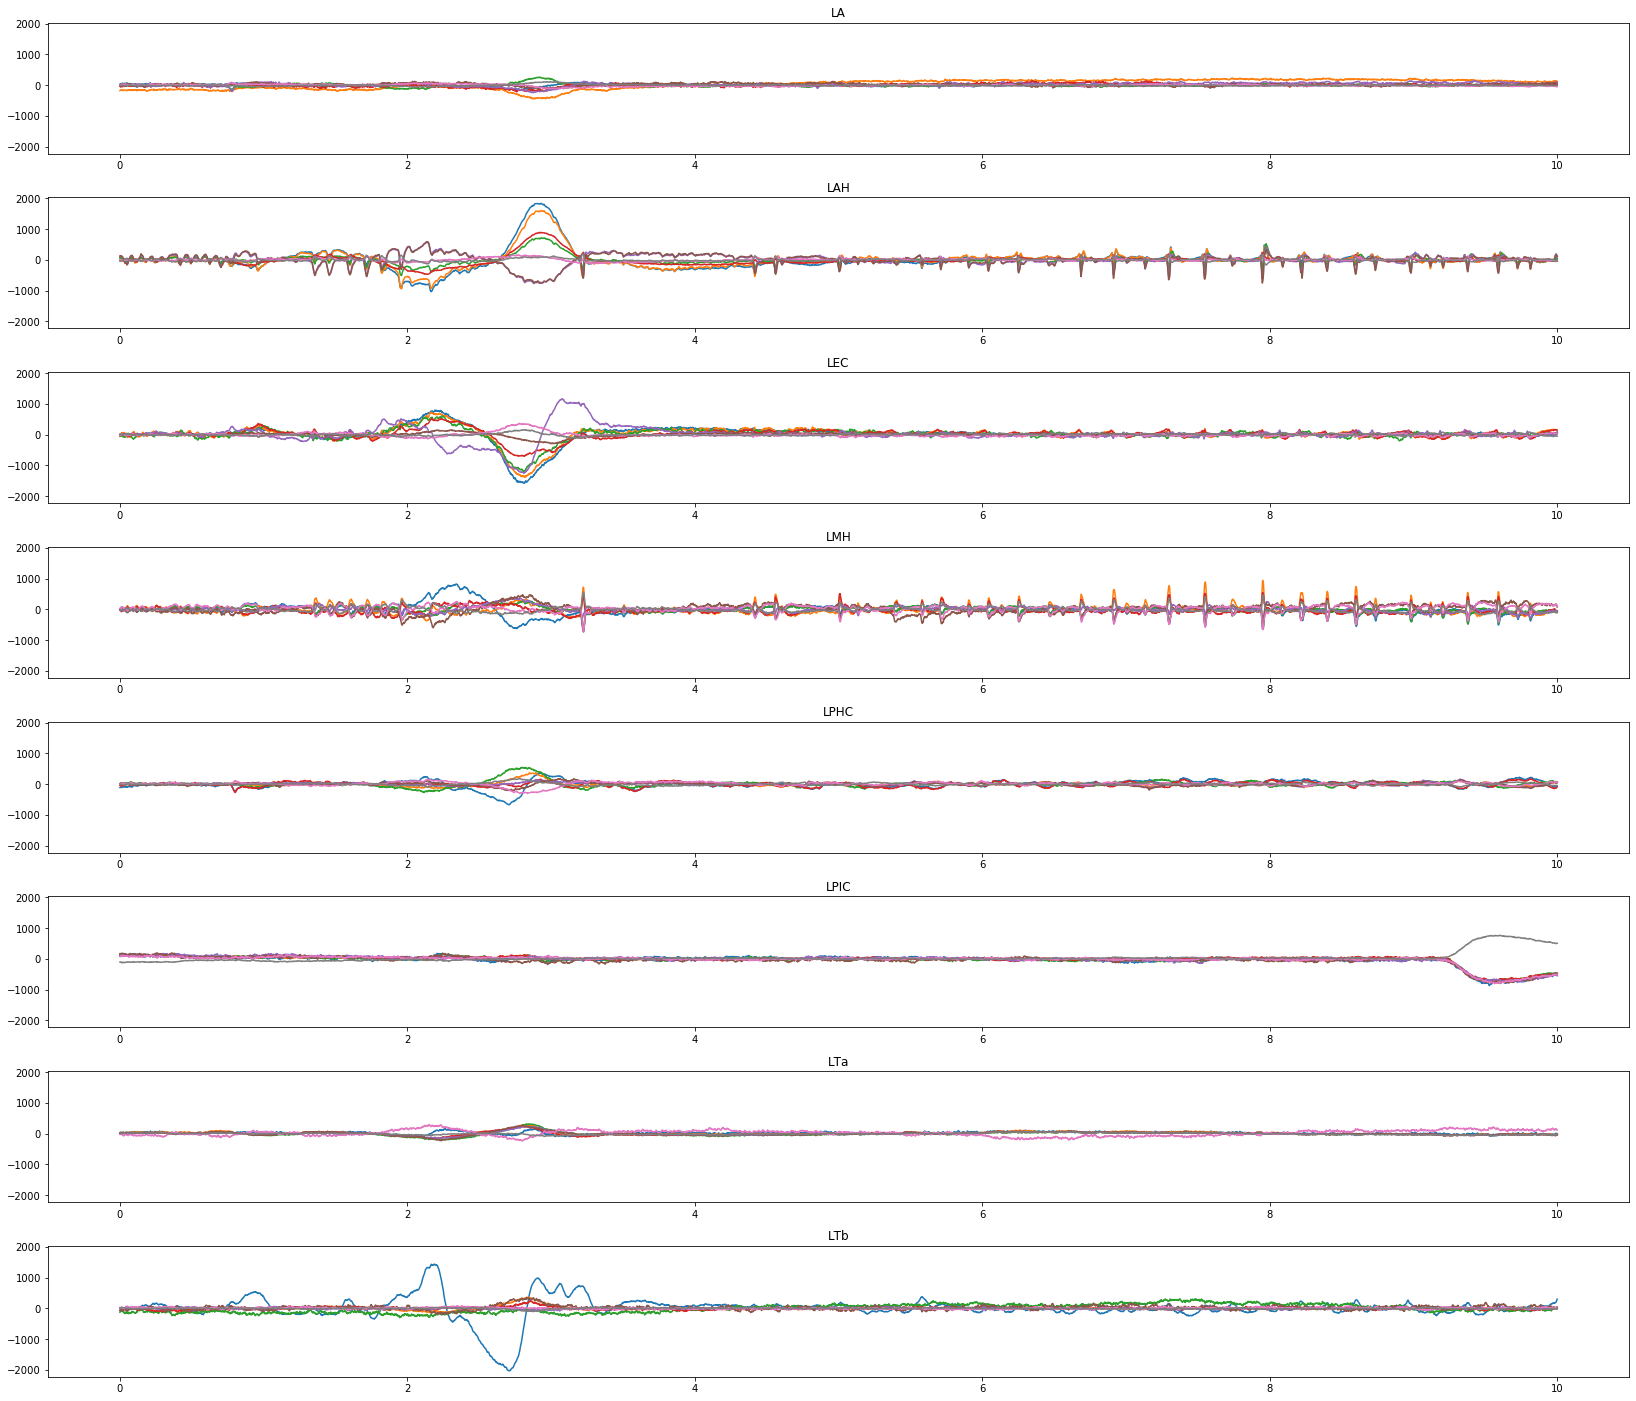

In [6]:
#plot all regions
my_dpi = 92
#all_regions = list(matfiles_dic.keys())
#all_onsets = [(31*60)+11]*len(all_regions)

fig, ax = plt.subplots(len(all_regions), figsize =(2100/my_dpi, 1800/my_dpi), sharey=True)
for ix, reg in enumerate(all_regions):
    curr_reg = matfiles_dic[reg]
    for i, ch in enumerate(curr_reg):
        file = readMatfile(os.path.join(reref_path, ch))
        data = file.reref_data[(all_onsets[ix]*sf):(all_onsets[ix]*sf)+(10*sf)]
        ax[ix].plot(np.linspace(0,len(data)/sf, len(data)), data)
        
    ax[ix].title.set_text(reg)
    
fig.tight_layout()
plt.show()

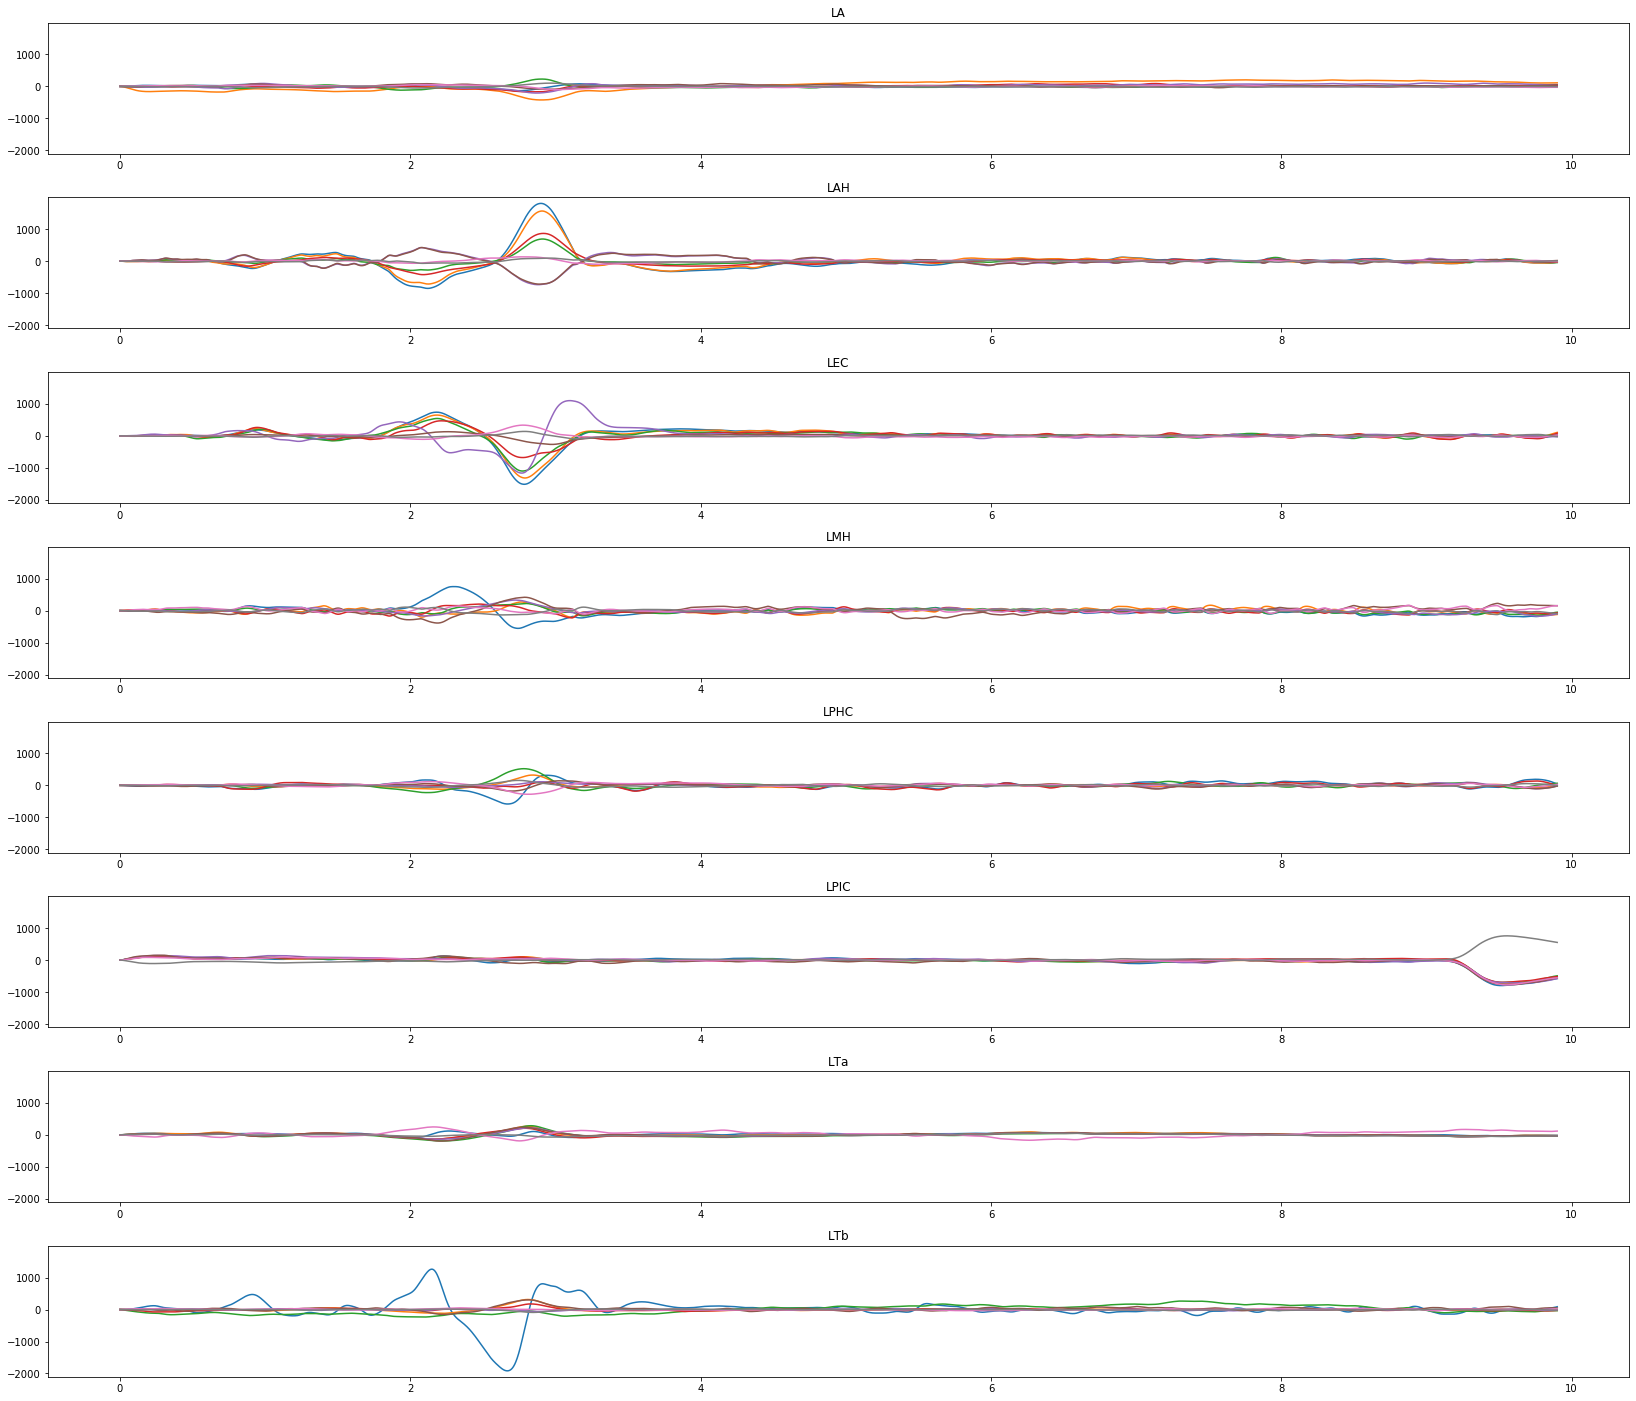

In [8]:
#plot all regions with a low-pass filter
my_dpi = 92
#all_regions = list(matfiles_dic.keys())
#all_onsets = [(30*60)+55]*len(all_regions)

fig, ax = plt.subplots(len(all_regions), figsize =(2100/my_dpi, 1800/my_dpi), sharey=True)
for ix, reg in enumerate(all_regions):
    curr_reg = matfiles_dic[reg]
    for i, ch in enumerate(curr_reg):
        file = readMatfile(os.path.join(reref_path, ch))
        data = file.reref_data[(all_onsets[ix]*sf):(all_onsets[ix]*sf)+(10*sf)]
        data = data[100:]
        filt = butter_lowpass_filter(data, 3, 1000, order=2)
        ax[ix].plot(np.linspace(0,len(data)/sf, len(data)), filt)
        
    ax[ix].title.set_text(reg)
    
fig.tight_layout()
plt.show()

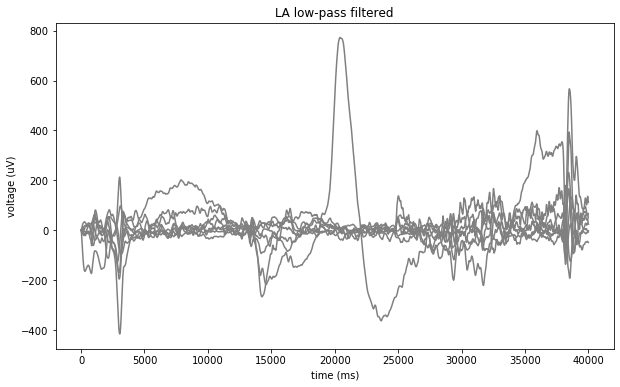

channels with SD: []
mean: nan ms


/tmp/ipykernel_35213/293864463.py:51: RuntimeWarning: Mean of empty slice
  print(f'mean: {np.nanmean(wave_delays[indices])} ms')


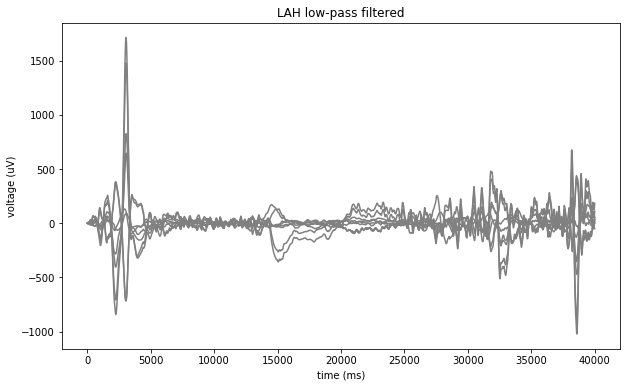

channels with SD: []
mean: nan ms


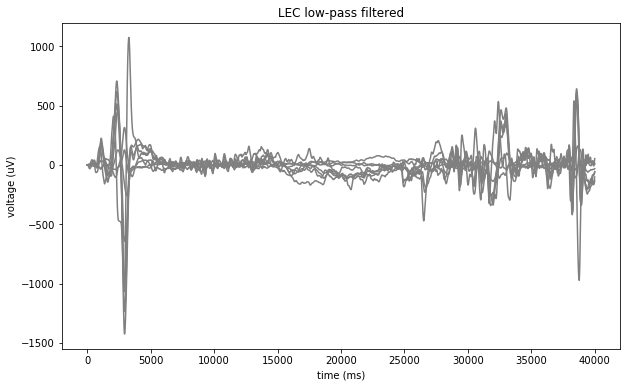

channels with SD: []
mean: nan ms


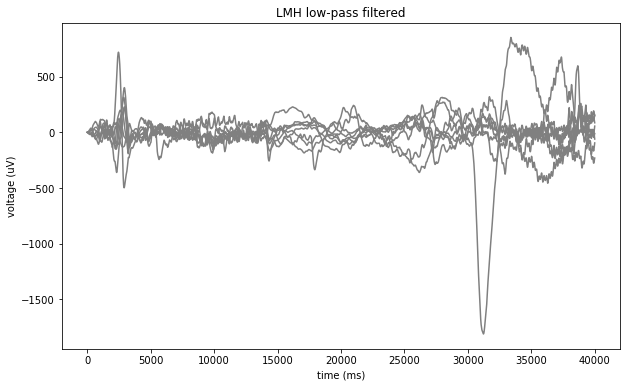

channels with SD: []
mean: nan ms


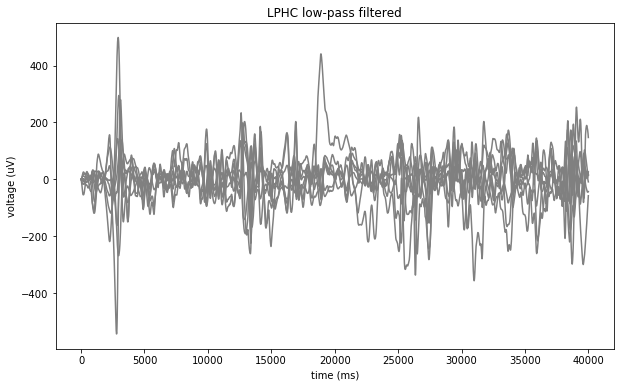

channels with SD: []
mean: nan ms


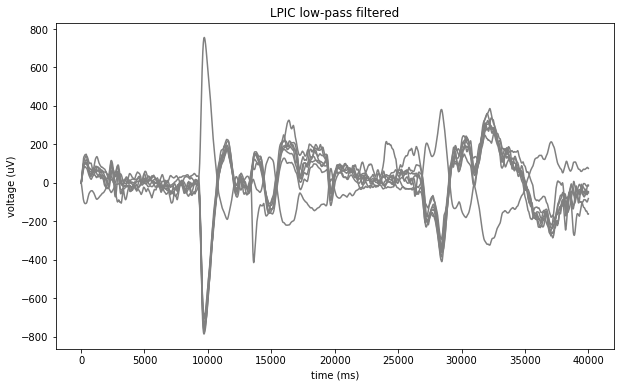

channels with SD: []
mean: nan ms


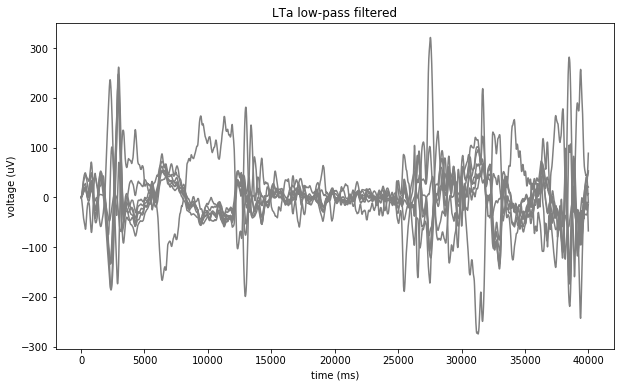

channels with SD: []
mean: nan ms


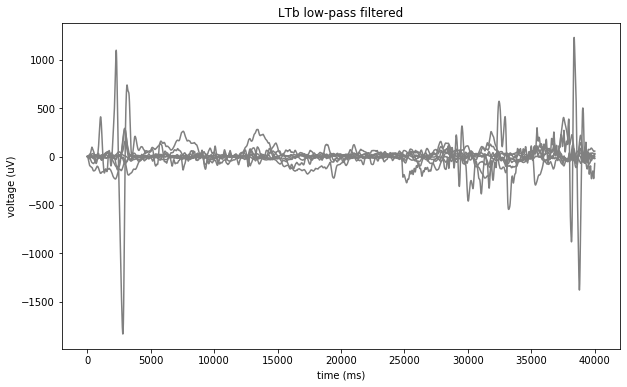

channels with SD: []
mean: nan ms


In [15]:
out_path = '/media/Seizures/Wenzel/temporospatial_analysis'
order=2
cutoff = 2
lengh_of_display = 40*1000
for ix, reg in enumerate(all_regions):
    curr_reg = matfiles_dic[reg]
    data_in_reg = []
    #get data
    for _, ch in enumerate(curr_reg):
        file = readMatfile(os.path.join(reref_path, ch))
        data_in_reg.append(file.reref_data[(all_onsets[0]*sf):(all_onsets[0]*sf)+(lengh_of_display)])
        
    #calculate delays
    wave_delays = get_wave_delays_per_wire(data_in_reg, onset_adjust_ms=150, 
                                           filter_order=order, lpf_cutoff_fr_hz=cutoff)

    #sort indices
    indices = np.argsort(wave_delays)
    indices = indices[:np.count_nonzero(~np.isnan(wave_delays))]
    #print(indices)

    #plot results
    tabcols = list(mcolors.TABLEAU_COLORS.keys())
    plt.figure(figsize=(10,6))
    
    for i, ind in enumerate(data_in_reg):
        curr_data = ind
        res = butter_lowpass_filter(curr_data, cutoff, 1000, order=order)
        curr_data = res[:lengh_of_display]
        plt.plot(curr_data, c='gray')
    
    
    for i, ind in enumerate(indices[:]):
        color = tabcols[i+1]

        curr_data = data_in_reg[ind]#[:2000]
        res = butter_lowpass_filter(curr_data, cutoff, 1000, order=order)
        curr_data = res[:lengh_of_display]
        xdot = int(wave_delays[ind])
        plt.plot(curr_data, c=mcolors.TABLEAU_COLORS[tabcols[i]] )
        plt.plot(xdot, curr_data[xdot], marker='o',label=str(xdot)+' ms')
        plt.legend()
    plt.xlabel('time (ms)')
    plt.ylabel('voltage (uV)')
    
    plt.title(reg+ ' low-pass filtered')
    #plt.savefig(os.path.join(out_path, f'{reg}_sd_delays'))
    plt.show()
    
    print(f'channels with SD: {indices}')
    print(f'mean: {np.nanmean(wave_delays[indices])} ms')

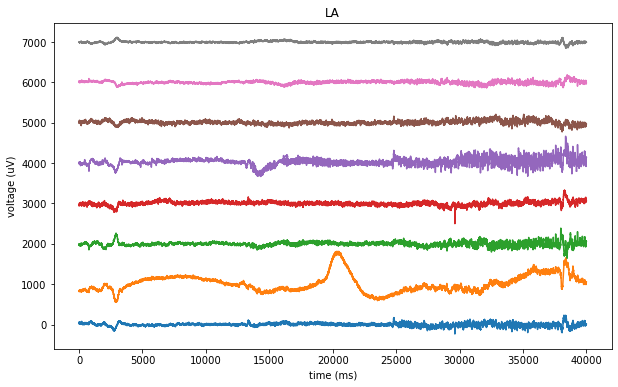

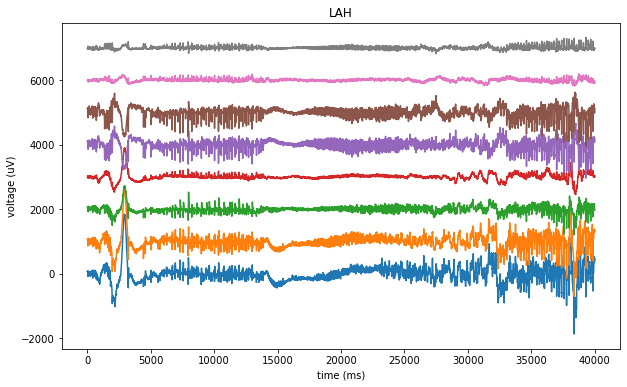

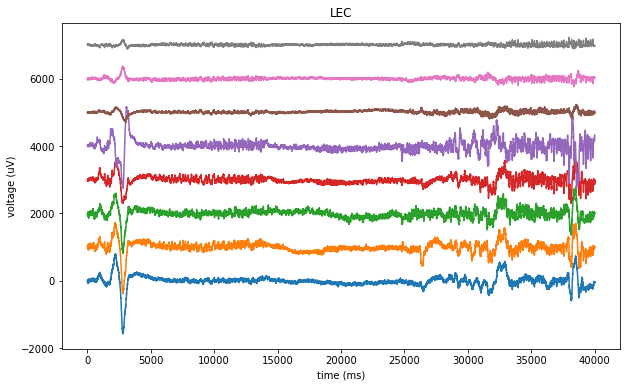

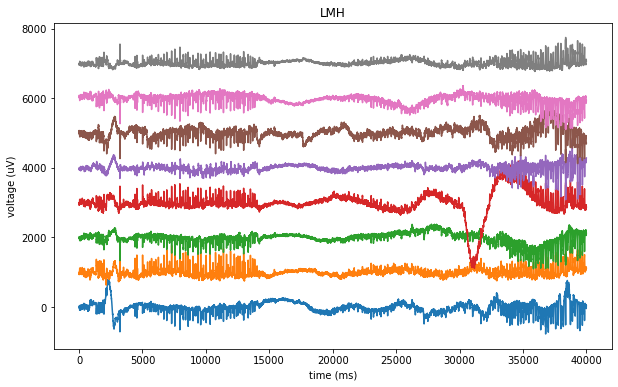

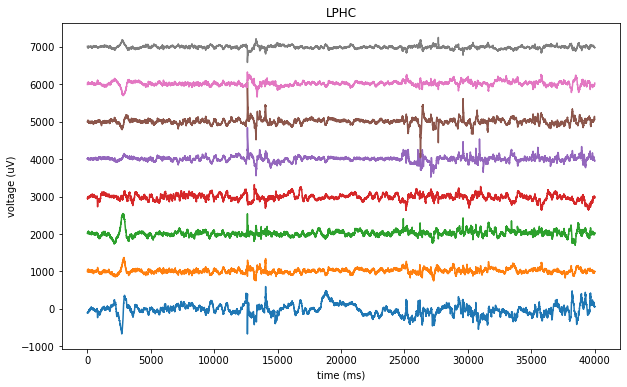

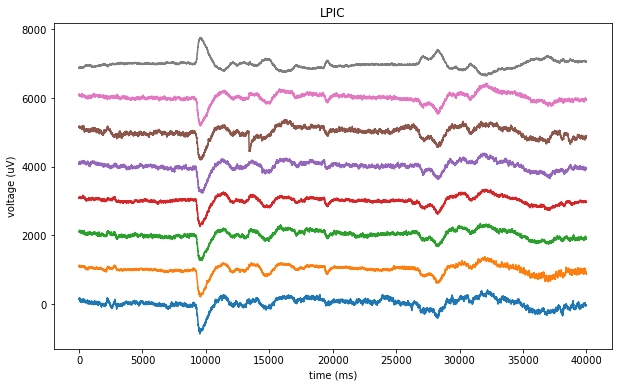

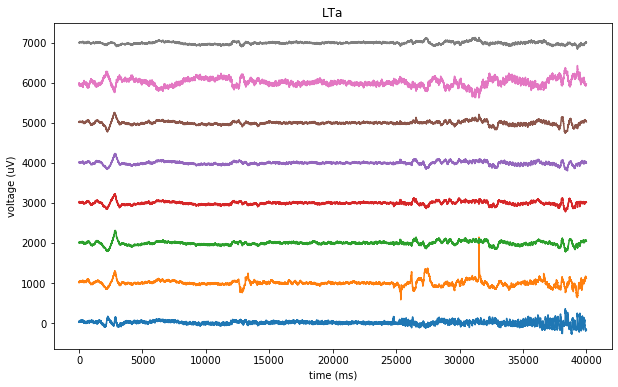

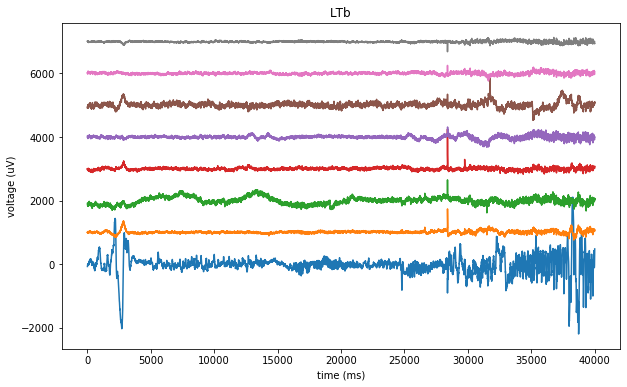

In [19]:
out_path = '/media/Seizures/Wenzel/temporospatial_analysis'
order=2
cutoff = 2
lengh_of_display = 40*1000
for ix, reg in enumerate(all_regions):
    curr_reg = matfiles_dic[reg]
    data_in_reg = []
    #get data
    for _, ch in enumerate(curr_reg):
        file = readMatfile(os.path.join(reref_path, ch))
        data_in_reg.append(file.reref_data[(all_onsets[0]*sf):(all_onsets[0]*sf)+(lengh_of_display)])
        
    '''#calculate delays
    wave_delays = get_wave_delays_per_wire(data_in_reg, onset_adjust_ms=150, 
                                           filter_order=order, lpf_cutoff_fr_hz=cutoff)

    #sort indices
    indices = np.argsort(wave_delays)
    indices = indices[:np.count_nonzero(~np.isnan(wave_delays))]
    #print(indices)

    #plot results
    tabcols = list(mcolors.TABLEAU_COLORS.keys())'''
    plt.figure(figsize=(10,6))
    
    y_tick = 0
    for i, ind in enumerate(data_in_reg):
        curr_data = ind
        #res = butter_lowpass_filter(curr_data, cutoff, 1000, order=order)
        #curr_data = res[:lengh_of_display]
        plt.plot(curr_data-y_tick)
        y_tick -= 2*500
    
    
    '''for i, ind in enumerate(indices[:]):
        color = tabcols[i+1]

        curr_data = data_in_reg[ind]#[:2000]
        res = butter_lowpass_filter(curr_data, cutoff, 1000, order=order)
        curr_data = res[:lengh_of_display]
        xdot = int(wave_delays[ind])
        plt.plot(curr_data, c=mcolors.TABLEAU_COLORS[tabcols[i]] )
        plt.plot(xdot, curr_data[xdot], marker='o',label=str(xdot)+' ms')
        plt.legend()'''
    plt.xlabel('time (ms)')
    plt.ylabel('voltage (uV)')
    
    plt.title(reg)
    #plt.savefig(os.path.join(out_path, f'{reg}_sd_delays'))
    plt.show()
    
    #print(f'channels with SD: {indices}')
    #print(f'mean: {np.nanmean(wave_delays[indices])} ms')

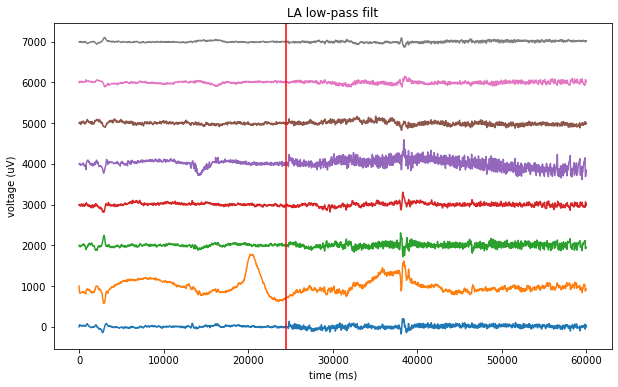

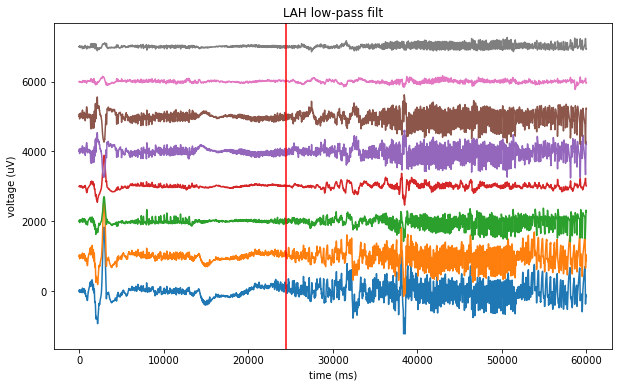

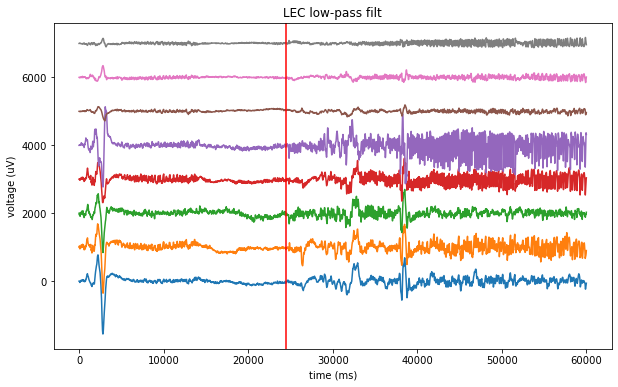

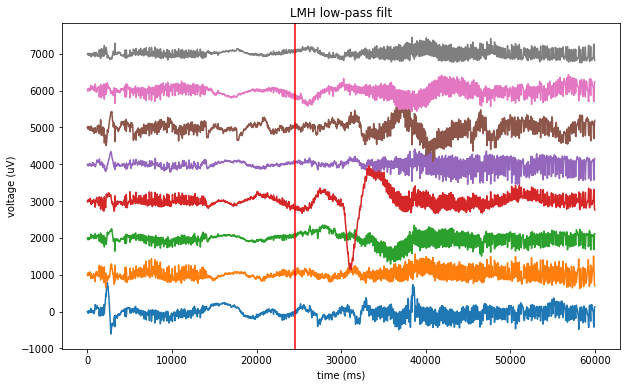

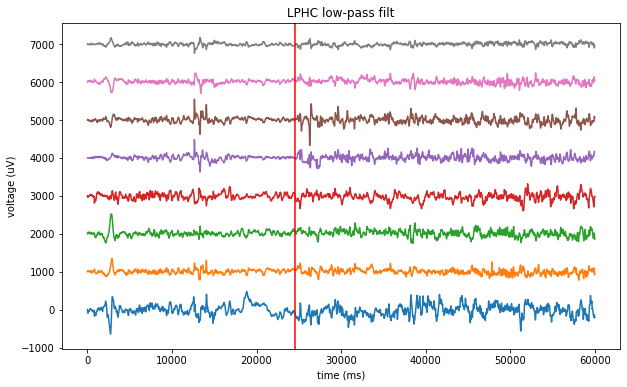

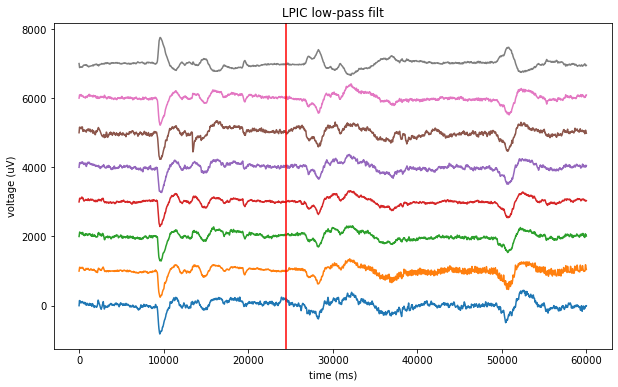

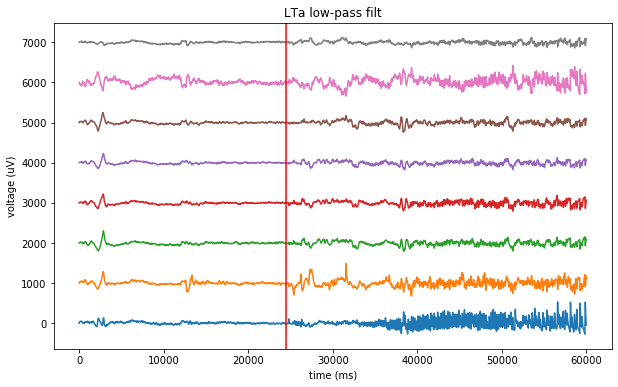

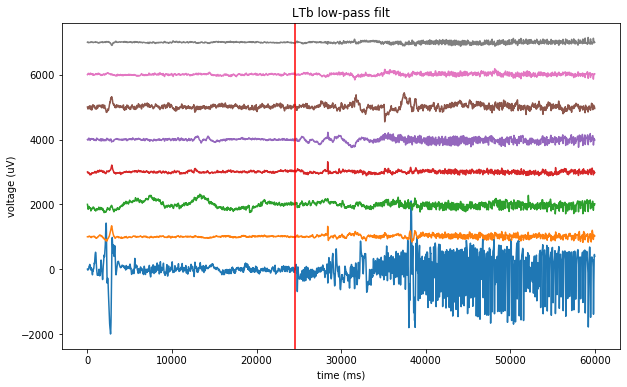

In [30]:
out_path = '/media/Seizures/Wenzel/temporospatial_analysis'
order=2
cutoff = 10
lengh_of_display = 60*1000
plot_offset = 
for ix, reg in enumerate(all_regions):
    curr_reg = matfiles_dic[reg]
    data_in_reg = []
    #get data
    for _, ch in enumerate(curr_reg):
        file = readMatfile(os.path.join(reref_path, ch))
        data_in_reg.append(file.reref_data[(all_onsets[0]*sf):(all_onsets[0]*sf)+(lengh_of_display)])
        
    '''#calculate delays
    wave_delays = get_wave_delays_per_wire(data_in_reg, onset_adjust_ms=150, 
                                           filter_order=order, lpf_cutoff_fr_hz=cutoff)

    #sort indices
    indices = np.argsort(wave_delays)
    indices = indices[:np.count_nonzero(~np.isnan(wave_delays))]
    #print(indices)

    #plot results
    tabcols = list(mcolors.TABLEAU_COLORS.keys())'''
    plt.figure(figsize=(10,6))
    
    y_tick = 0
    for i, ind in enumerate(data_in_reg):
        curr_data = ind
        res = butter_lowpass_filter(curr_data, cutoff, 1000, order=order)
        curr_data = res[:lengh_of_display]
        plt.plot(curr_data-y_tick)
        y_tick -= 2*500
    
    
    '''for i, ind in enumerate(indices[:]):
        color = tabcols[i+1]

        curr_data = data_in_reg[ind]#[:2000]
        res = butter_lowpass_filter(curr_data, cutoff, 1000, order=order)
        curr_data = res[:lengh_of_display]
        xdot = int(wave_delays[ind])
        plt.plot(curr_data, c=mcolors.TABLEAU_COLORS[tabcols[i]] )
        plt.plot(xdot, curr_data[xdot], marker='o',label=str(xdot)+' ms')
        plt.legend()'''
    plt.xlabel('time (ms)')
    plt.ylabel('voltage (uV)')
    
    plt.title(reg+' low-pass filt')
    plt.axvline(x=24500, color='r')
    #plt.savefig(os.path.join(out_path, f'{reg}_sd_delays'))
    plt.show()
    
    #print(f'channels with SD: {indices}')